<a href="https://colab.research.google.com/github/gaellequillaud/Molecular_Property_Prediction_GNN/blob/main/Molecular_Property_Prediction_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Molecular Property Prediction Using Graph Neural Networks**


## **1. Install RDkit and PyTorch Geometric**



In [ ]:
! pip install rdkit
! pip install torch_geometric

---

## **2. Solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt). The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).$^1$

### **2.1. Download the dataset**

In [ ]:
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

If the previous link doesn't work, use :

In [ ]:
! wget https://raw.githubusercontent.com/gaellequillaud/Molecular_Property_Prediction_GNN/main/delaney.csv

### **2.2. Read in the dataset**

In [5]:
import pandas as pd

In [36]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


---

## **3. Calculate molecular descriptors in RDKit**

### **3.1. Convert list of molecules to rdkit object**

In [8]:
from rdkit import Chem

In [12]:
mol_list = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [13]:
len(mol_list)

1144

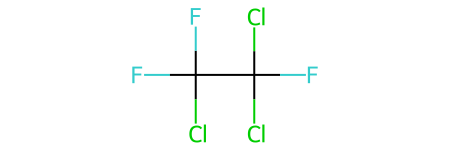

In [19]:
mol_list[4]

In [35]:
mol_list[:4]

### **3.2. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **3.2.1. LogP, MW and RB**

In [20]:
import numpy as np
from rdkit.Chem import Descriptors

In [21]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [22]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### **3.2.2. Aromatic proportion**

##### **3.2.1.1. Number of aromatic atoms**

Here, we will create a custom function to calculate the **Number of aromatic atoms**. With this descriptor we can use it to subsequently calculate the AP descriptor.

In [23]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [ ]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

##### **3.2.1.2. Number of heavy atoms**

Here, we will use an existing function for calculating the Number of heavy atoms.

In [ ]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

##### **3.2.1.3. Computing the Aromatic Proportion (AP) descriptor**

In [ ]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

In [ ]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

### **3.3. X matrix (Combining all computed descriptors into 1 dataframe)**

Let's combine the 2 dataframes to produce the **X** matrix

In [28]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### **3.4. Y matrix**

In [29]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix, which corresponds to the measured log(solubility:mol/L)

In [ ]:
Y = sol.iloc[:,1]
Y

---

## **4. Data split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [33]:
print(X.head())

   MolLogP    MolWt  NumRotatableBonds  AromaticProportion
0   2.5954  167.850                0.0                 0.0
1   2.3765  133.405                0.0                 0.0
2   2.5938  167.850                1.0                 0.0
3   2.0289  133.405                1.0                 0.0
4   2.9189  187.375                1.0                 0.0


In [32]:
Y.head()

0   -2.18
1   -2.00
2   -1.74
3   -1.48
4   -3.04
Name: measured log(solubility:mol/L), dtype: float64

---

## **5. Graph Neural Network model**

### **5.1. Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from rdkit import Chem

### **5.2. Convert SMILES to graph representation**

In [37]:
def smiles_to_graph(smiles):
    """
    Convert SMILES representation of a molecule into a PyTorch Geometric Data object.

    Args:
    - smiles (str): SMILES representation of the molecule

    Returns:
    - PyTorch Geometric Data object representing the molecule
    """
    mol = Chem.MolFromSmiles(smiles)
    # Convert mol to graph representation (you already have a function for this)
    # Return PyTorch Geometric Data object
    return mol_to_graph(mol)  # Implement this function based on your existing code


### **5.3. Prepare Data for Training and Testing**

In [ ]:
graph_data = [smiles_to_graph(smiles) for smiles in sol.SMILES]

# Split data into train and test sets
X_train, X_test, Y_train, Y_test, graph_train, graph_test = train_test_split(X, Y, graph_data, test_size=0.2, random_state=42)

---

# Data preprocessing

## Preprocessing ?

## Conversion from SMILES to RDKit to Graph


In [61]:
import torch
import torch_geometric.utils as pyg_utils
from rdkit import Chem

In [62]:
def smiles_to_graph(smiles, label):
    """
    Convert SMILES representation of a molecule into a PyTorch Geometric Data object.

    Args:
    - smiles (str): SMILES representation of the molecule
    - label (int): Label for the molecule

    Returns:
    - PyTorch Geometric Data object representing the molecule with label
    """
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    # Create an empty graph
    num_nodes = mol.GetNumAtoms()
    edge_index = []
    x = []  # Node features
    for i, atom in enumerate(mol.GetAtoms()):
        atom_features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetTotalNumHs(),
            # Add more features as needed
        ]
        x.append(atom_features)

        # Add edges for bonds
        for bond in atom.GetBonds():
            j = bond.GetOtherAtomIdx(i)
            edge_index.append([i, j])

    # Convert to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

    return Data(x=x, edge_index=edge_index, y=y)

# Graph Neural Network

In [63]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

## Model

In [64]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [65]:
dataCCO = smiles_to_graph("CCO", 1)
# Define the dimensions for the input, hidden, and output layers
input_dim = len(dataCCO.x[0])
hidden_dim = 64
output_dim = 2  # Number of classes (for classification task)

# Instantiate the GCN model
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [84]:
smiles_list = [["CCO", 1], ["CN=C=O", 1], ["C1=CC1", 0], ["CCC(=O)O", 0], ["N#N", 1], ["[Cu+2].[O-]S(=O)(=O)[O-]", 0]]
dataset = [smiles_to_graph(smiles, label) for smiles, label in smiles_list]
print(dataset)

[Data(x=[3, 3], edge_index=[2, 4], y=1), Data(x=[4, 3], edge_index=[2, 6], y=1), Data(x=[3, 3], edge_index=[2, 6], y=0), Data(x=[5, 3], edge_index=[2, 8], y=0), Data(x=[2, 3], edge_index=[2, 2], y=1), Data(x=[6, 3], edge_index=[2, 8], y=0)]


## DataLoaders

In [67]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.data import Dataset
from torch_geometric.data import Batch

In [82]:
# Assuming you have a list of PyTorch Geometric Data objects representing your molecules
# You may need to load your data and convert it into PyTorch Geometric Data objects first

# Split the dataset into train and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

def custom_collate(batch):
    return Batch.from_data_list(batch)

# Define batch size
batch_size = 32

# Create DataLoader instances for train and test sets using the custom collate function
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

## Training

In [ ]:
# Train the GCN model (you need to define your training loop)
# For simplicity, let's assume 'train_loader' is your DataLoader for training data
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

## Evaluation

In [ ]:
# Evaluate the GCN model (you need to define your evaluation loop)
# For simplicity, let's assume 'test_loader' is your DataLoader for test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        _, predicted = torch.max(out, 1)
        total += batch.y.size(0)
        correct += (predicted == batch.y).sum().item()

    accuracy = correct / total
    print('Accuracy:', accuracy)